In [1]:
import numpy as np
from snowfall.nn import Network, SnowModule
import pandas as pd
import seaborn as sns

In [2]:
iris = pd.read_csv("iris.csv")

In [3]:
from sklearn.preprocessing import LabelEncoder
data = pd.DataFrame()
encoder = LabelEncoder()
data["sl"] = iris["sepal.length"]
data["sw"] = iris["sepal.width"]
data["pl"] = iris["petal.length"]
data["pw"] = iris["petal.width"]
data["cls"] = encoder.fit_transform(iris["variety"])

In [4]:
data

,sl,sw,pl,pw,cls
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


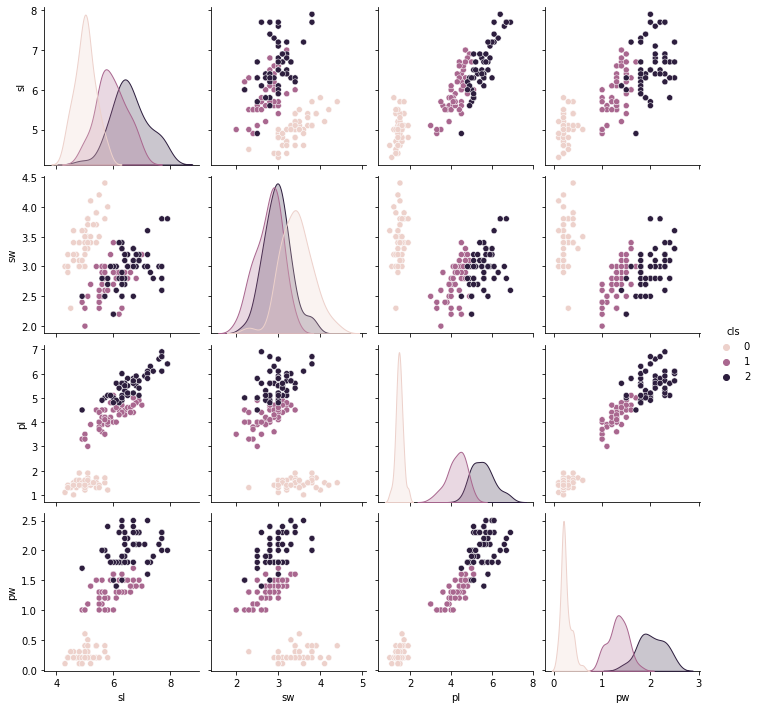

In [5]:
sns.pairplot(data, hue="cls")

In [6]:
from sklearn.model_selection import train_test_split
x,y = data.drop("cls", axis=1), data["cls"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.24)
x_train, x_test, y_train, y_test = x_train.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [7]:
from torch.utils.data import TensorDataset
import torch

train = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
test = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())

In [8]:
from snowfall.manager.execution_manager import ExecutionManager
from snowfall.nn import SnowModule, Network
from snowfall.generalization import DisturbLabel, EarlyStopping, L2Regularize
import torch.nn as nn

net = Network()
net += nn.Linear(4, 12)
net += nn.Linear(12, 36)
net += nn.Linear(36, 3)

manager = ExecutionManager(use_gpu=False)
disturber = DisturbLabel(alpha=.05, class_count=3)

def disturb(x, y):
    return x, disturber(y)

def accuracy(pred, gt):
    pred = pred.argmax(dim=1, keepdim=True)
    correct = pred.eq(gt.view_as(pred)).sum()
    return correct.float() / pred.shape[0]

c = SnowModule(manager)
c += net
c *= "adam"
c -= L2Regularize(nn.CrossEntropyLoss(), 0.001)
c %= ("acc", accuracy)
c |= (disturb, False)
c **= EarlyStopping(patience=10)
c.learn(train, epochs=24, train_batch=4, val_batch=4)

Validating Epoch 23: 100%|██████████| 5/5 [00:00<00:00, 714.24it/s, acc=1, loss=0.0916, mean_loss=0.132]


In [9]:
result, info = c.evaluate(test)

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.97it/s, acc=1, loss=0.112, mean_loss=0.103]


In [10]:
info

{'acc': 1.0, 'loss': 0.10252740234136581}